This notebook does DBSCAN clustering on 10s subintegrations of 121 continuous minute observations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import os
import pandas as pd
import psrchive

In [2]:
from scipy.optimize import curve_fit
from scipy.stats import skew, kurtosis
from scipy.stats import normaltest

In [3]:
import corner
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io.output import output_notebook
import base64
from io import BytesIO

In [4]:
from bokeh.palettes import Viridis256 
from matplotlib.colors import Normalize, to_hex
from matplotlib import cm

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
cd /idia/projects/pulsar-timing/users/athambiran/MSc_NGC6440A/timing/121mins_10sub/

/idia/projects/pulsar-timing/users/athambiran/MSc_NGC6440A/timing/121mins_10sub


In [7]:
data = np.loadtxt("final_residuals.txt") 

In [8]:
data[0] #sat bat freq residual(post;second) err(errorbars; microsec) snr

array([5.86827791e+04, 5.86827729e+04, 1.28307300e+03, 1.29522613e-02,
       1.35958600e+03, 1.58760000e+01])

<ErrorbarContainer object of 3 artists>

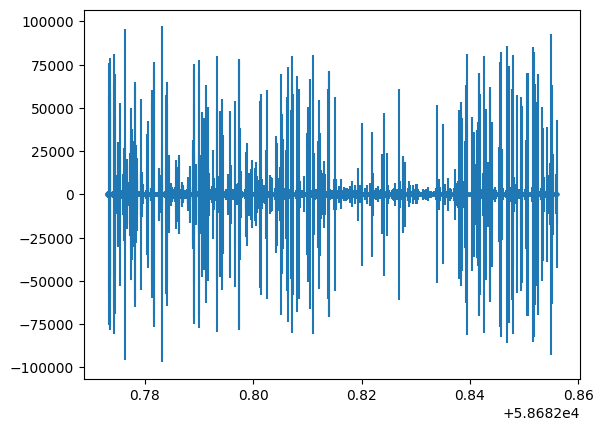

In [9]:
plt.errorbar(data[:,1],data[:,3], yerr=data[:,4], fmt="o", markersize=2)

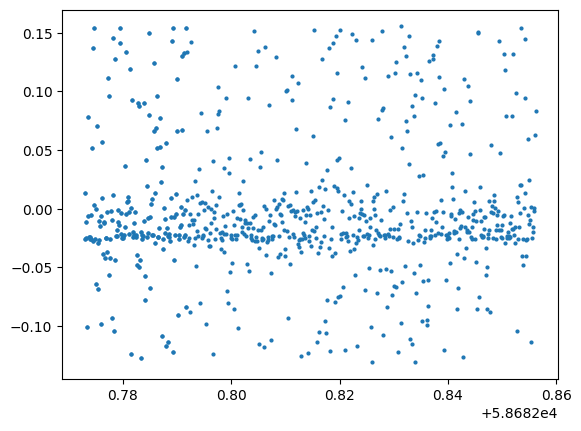

In [10]:
plt.scatter(data[:,1],data[:,3],s=4)

In [11]:
sizes = data[:,5]

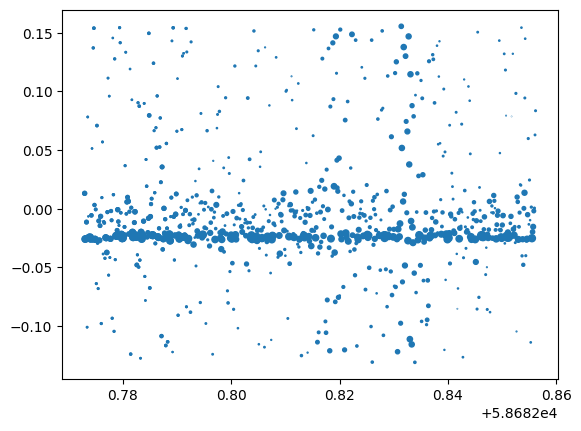

In [12]:
plt.scatter(data[:,1],data[:,3],s=sizes*0.5)

In [13]:
dbscan_data = []
dbscan_data = np.column_stack((data[:, 4], data[:, 3], data[:,5]))  #bat, residual, snr

In [14]:
# Scale them so each feature has mean=0 and std=1
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dbscan_data)

In [15]:
scaled_data[0]

array([-0.57171378,  0.2170863 ,  0.16221163])

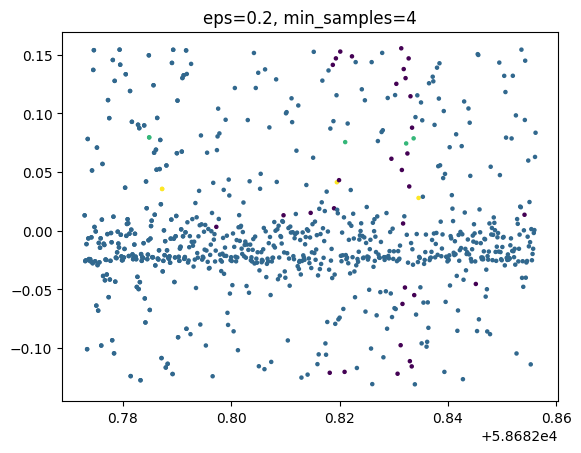

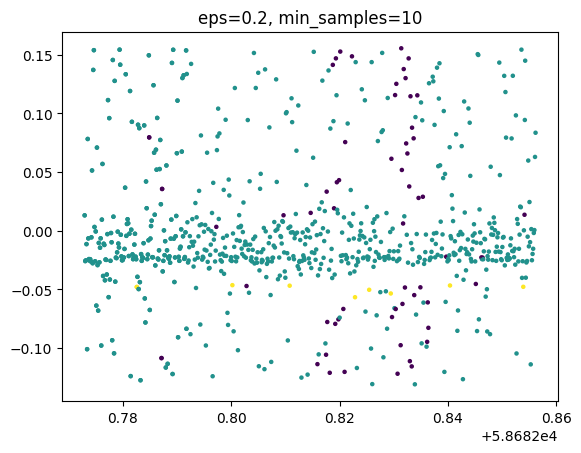

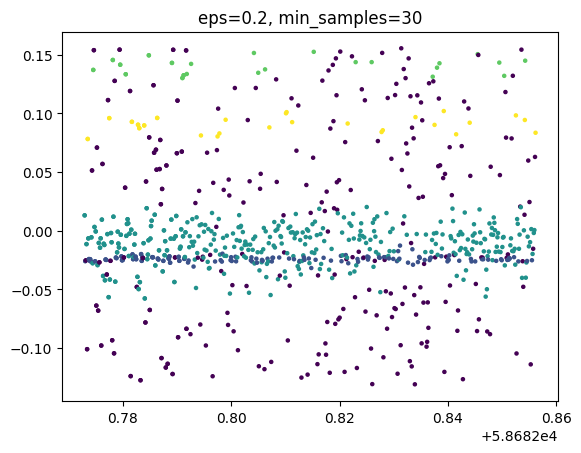

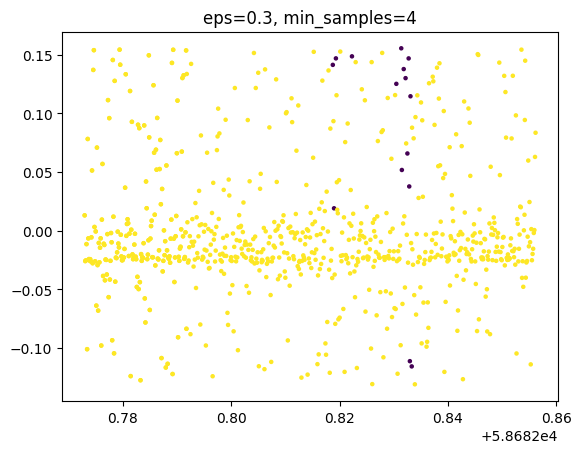

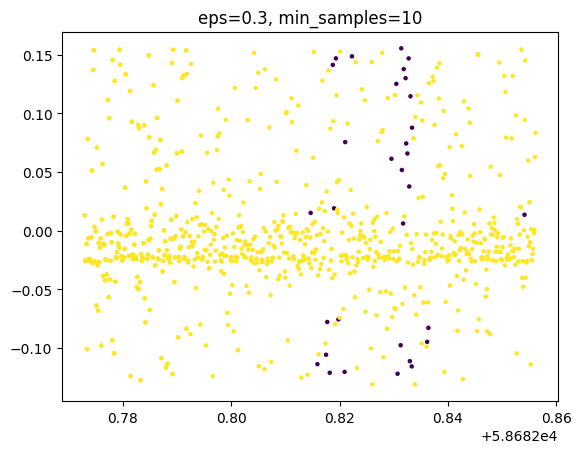

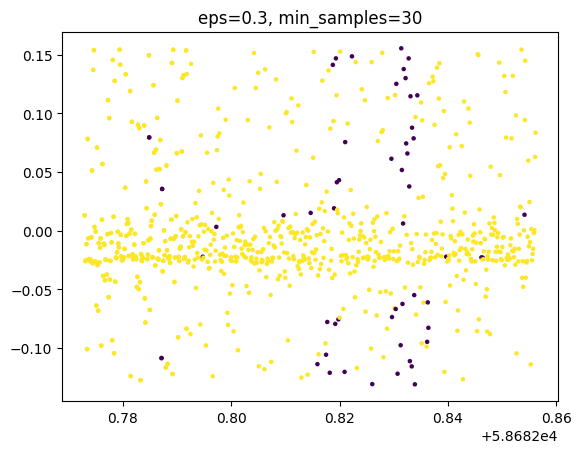

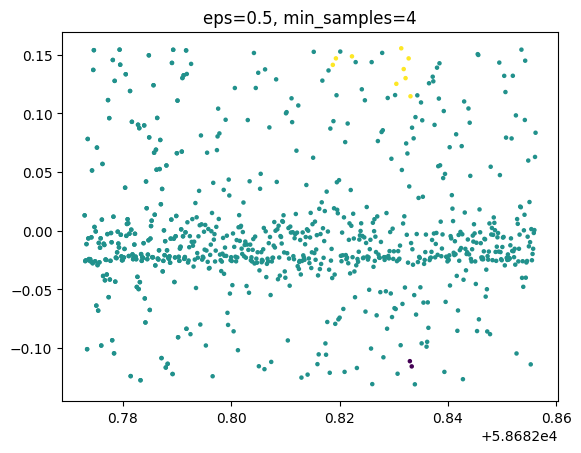

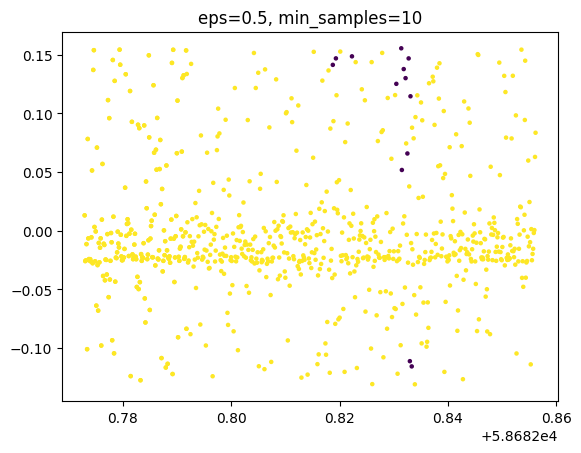

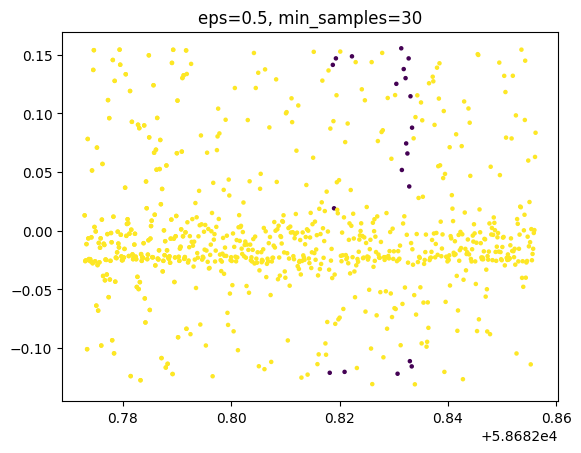

In [16]:
for eps in [0.2, 0.3, 0.5]:
    for min_samples in [4, 10, 30]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled_data[:, 1:])
        plt.scatter(data[:,1], data[:,3], s=5, c=labels, cmap='viridis')
        plt.title(f"eps={eps}, min_samples={min_samples}")
        plt.show()

In [17]:
dbscan_data = []
dbscan_data = np.column_stack((data[:, 3], data[:,5]))  #residual, snr

In [18]:
# Scale them so each feature has mean=0 and std=1
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dbscan_data)

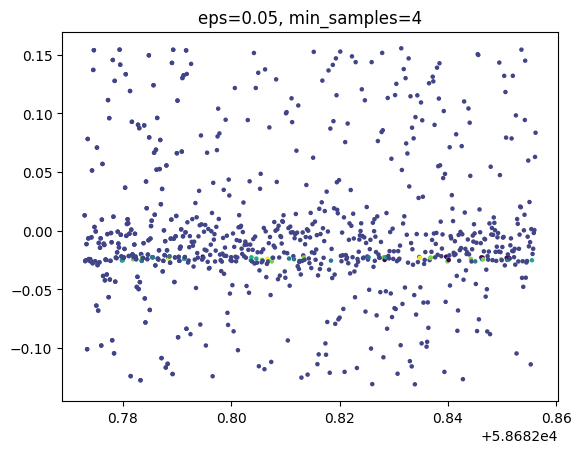

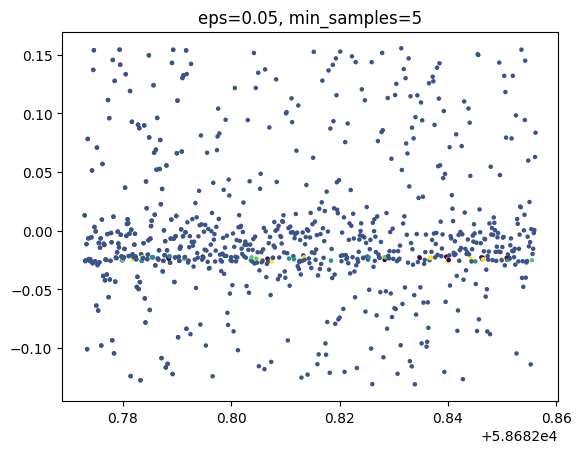

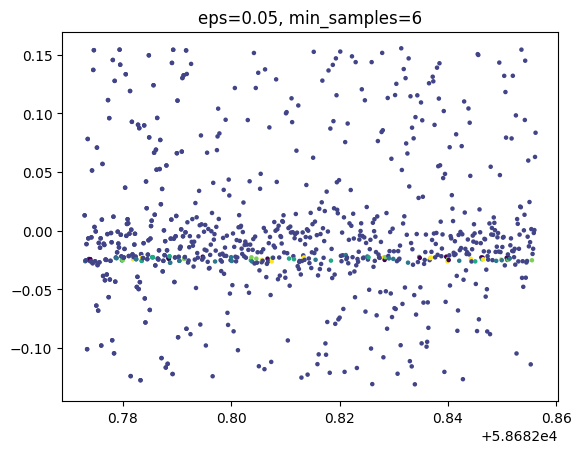

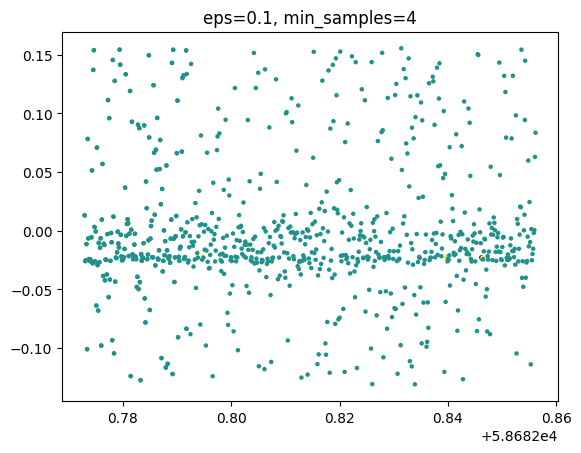

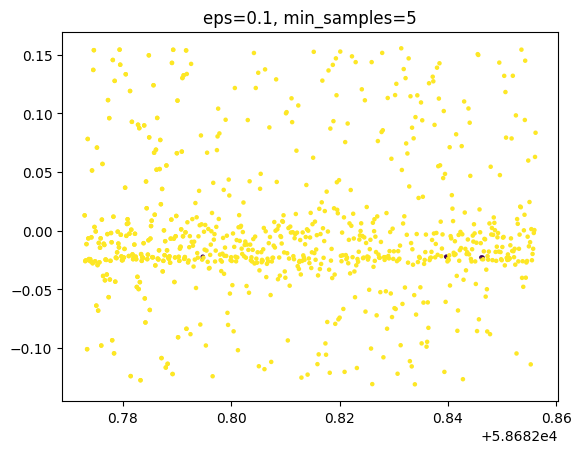

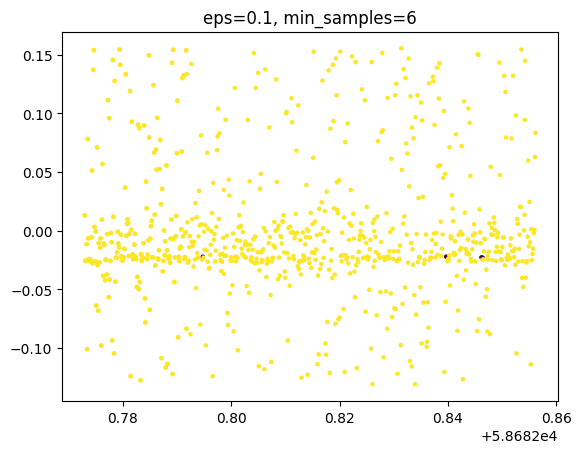

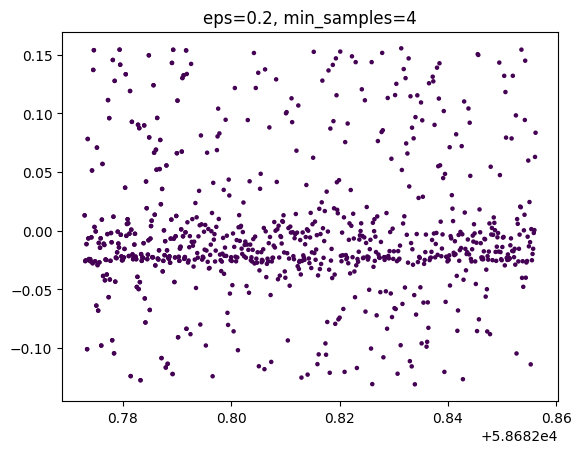

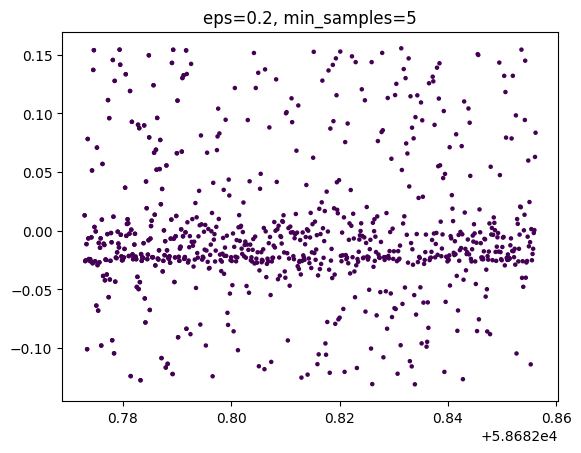

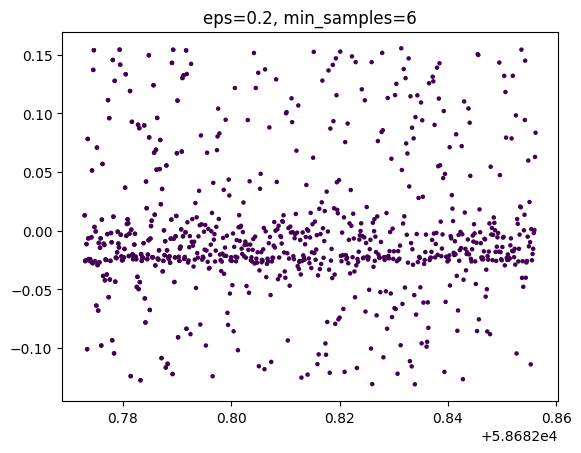

In [19]:
for eps in [0.05, 0.1, 0.2]:
    for min_samples in [4, 5, 6]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled_data[:, 1:])
        plt.scatter(data[:, 1], data[:, 3], s=5, c=labels, cmap='viridis')
        plt.title(f"eps={eps}, min_samples={min_samples}")
        plt.show()

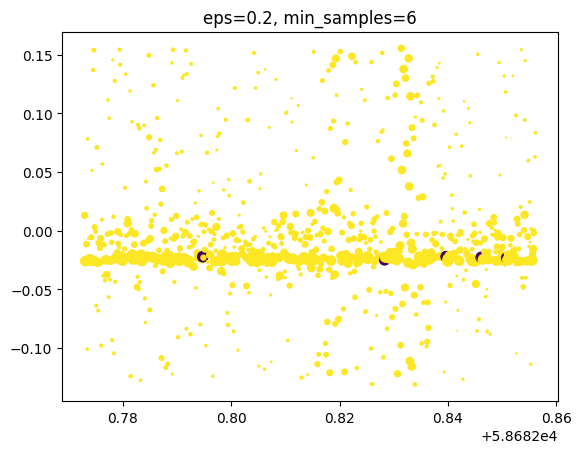

In [20]:
dbscan = DBSCAN(eps=0.2, min_samples=30)
labels = dbscan.fit_predict(scaled_data[:, 1:])
plt.scatter(data[:,1], data[:,3], s=data[:,5], c=labels, cmap='viridis')
plt.title(f"eps={eps}, min_samples={min_samples}")
plt.show()

In [21]:
arch = psrchive.Archive_load("121mins.t10.f4.pazi")

In [22]:
arch.remove_baseline()
arch.dedisperse()

In [23]:
arch.convert_state("Stokes")
arch.get_state()

'Stokes'

In [24]:
arch.fscrunch()
arch.bscrunch(4)

In [25]:
data_for_profiles = arch.get_data().squeeze()

In [26]:
np.shape(data_for_profiles) ## time, Stokes, bins (1024/4)

(912, 4, 256)

In [27]:
obs_duration = arch.integration_length()
num_chan = arch.get_nchan()
num_subint = arch.get_nsubint()
num_bins = arch.get_nbin()
num_pol = arch.get_npol()
pol_state = arch.get_state()

print(f'And has the following characteristics:\n')
print(f'Observation duration of \t\t\t {obs_duration:.2f} seconds')
print(f'Number of frequency channels\t\t\t {num_chan}')
print(f'Number of polarisations \t\t\t {num_pol}')
print(f'In polarisation state \t\t\t\t {pol_state}')
print(f'Number of subintegrations (time blocks)\t\t {num_subint}')
print(f'Each subintegration (time block) is made up of   {num_bins} data bins')

And has the following characteristics:

Observation duration of 			 8826.67 seconds
Number of frequency channels			 1
Number of polarisations 			 4
In polarisation state 				 Stokes
Number of subintegrations (time blocks)		 912
Each subintegration (time block) is made up of   256 data bins


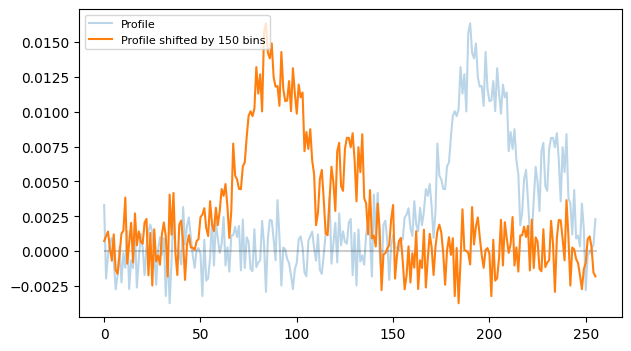

In [28]:
### Make one plot of subint X to see if we want to center peaks
subint_num = 2

plt.figure(figsize=(7,4))
plt.plot(data_for_profiles[subint_num,0,:], label="Profile", alpha = 0.3)
plt.hlines(0, 0, 256, color = 'black', alpha = 0.2)

roll_with = 150
data_for_profiles_rolled = np.roll(data_for_profiles,roll_with, axis=2) ##note axis 2 is the bins axis
plt.plot(data_for_profiles_rolled[subint_num,0,:], label="Profile shifted by %d bins" %roll_with)
plt.legend(fontsize=8, loc='best')
plt.show()

In [29]:
cd csvs

/idia/projects/pulsar-timing/users/athambiran/MSc_NGC6440A/timing/121mins_10sub/csvs


In [30]:
for subint in range(num_subint):
    df = pd.DataFrame(data_for_profiles_rolled[subint,:,:].T,columns=["I","Q","U","V"]) ##transpose to have I, Q, U, V as columns (instead of rows)
    df.to_csv("Profile_stokes_%d.csv" %subint, index=False)

In [31]:
np.shape(data_for_profiles_rolled)

(912, 4, 256)

In [32]:
images = []

In [33]:
bats = data[:,1]
residuals = data[:,3]

In [34]:
#Create a colormap from DBSCAN labels
unique_labels = np.unique(labels)
norm = Normalize(vmin=unique_labels.min(), vmax=unique_labels.max())
cmap = plt.get_cmap('viridis')

colors = [to_hex(cmap(norm(label))) if label != -1 else '#ff0000'  # Red for noise
          for label in labels]

In [ ]:
for subint in range(num_subint):
    intensities = data_for_profiles_rolled[subint, 0, :]

    #matplotlib figure of the profile
    fig, ax = plt.subplots()
    ax.plot(intensities, color='blue',alpha=0.7)
    #ax.set_title(f"Subint {subint}")
    #ax.axis("off")  # Hide axes for cleaner display
    
    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight')
    plt.close(fig)
    
    encoded = base64.b64encode(buf.getvalue()).decode()
    images.append(f"<img src='data:image/png;base64,{encoded}' width='300'>")

output_notebook()

#Bokeh data source
source = ColumnDataSource(data=dict(
    bat=bats,
    residual=residuals,
    #subint=subints_list.astype(str),
    image=images,
    color=colors
))

p = figure(title="BAT vs Residual", width=800, height=600,
           x_axis_label="BAT", y_axis_label="Residual",
           tools="pan,wheel_zoom,reset")

p.scatter("bat", "residual", size=8, color="color", alpha=0.5, source=source)

#image of profiles when hovering
hover = HoverTool(tooltips="""
    <div>
        <span style="font-size: 12px;">abc
        @image
    </div>
""")

#box = BoxZoomTool()
p.add_tools(hover)

show(p)